# Demostration and Documentation of the Im2LaTeX Model

This notebook contains the example of the workflow of the project, you may get yourself familiar with this project by going through the following steps.

Before you getting start, make sure that you have all dependencies installed. And the recommended Python version would be `Python >= 3.8.13`

### Dependencies:

* torch
* torchvision
* pillow
* nltk
* editdistance
* pandas
* numpy
* matplotlib

You can install these dependencies using the following command.

In [ ]:
#!pip3 install -r requirement.txt

## Data Preprocessing Using `DataReader`

This document aims to show the whole process of data preprocessing using the `DataReader` from `utils` and **standardize** the shape of the input to the model. This document also serves as the documentation for the `DataReader` You may follow the steps to know how the data is fitted.

### Load the data from the directory

We initialize the `DataReader` by sending the root directory, image subdirectory and the name of the annotation file. 

You may need to keep the original directory relationship of the dataset provided by the repo.

In [1]:
from utils import datareader

# Data direcotry
data_root_dir = "../datasets/im2latex-100k/"
image_dir = "images/" # The image directory in under data_root_dir

# The name of the annotation file
train_ann_path = "im2latex_train.csv"
dev_ann_path = "im2latex_validate.csv"
test_ann_path = "im2latex_test.csv"

reader = datareader.DataReader(data_root_dir, image_dir, train_ann_path, dev_ann_path, test_ann_path)

/Users/zhuangcheng/opt/anaconda3/envs/ltx_prj/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, call the function `read_data(train_data_size, dev_data_size, test_data_size)` to get the tuple `train_data`, `dev_data` and `test_data`.

You can detach the image_tensors and formulas from these tuple: 
 - `image_tensor = data[0]`
 - `formulas = data[1]`

Parameters:

 - `train_data_size` decides how many samples from the train set used
 - `dev_data_size` decides how many samples from the dev set used 
 - `test_data_size` decides how many samples from the test set used 

 **[IMPORTANT] If you want to read all data, set the data size greater than the number of data in the set**

Outputs:

 - data tuples containing:

    - `image_tensors` contains the digitalized images shaped *(Number of Images, Channel, Height, Width)*
    - `formulas` is a `pd.Series` contains formula sequences

In [2]:
TRAIN_DATA_SIZE = 1000
DEV_DATA_SIZE = 100
TEST_DATA_SIZE = 10

train_data, dev_data, test_data = reader.read_data(train_data_size=TRAIN_DATA_SIZE, 
                                                  dev_data_size=DEV_DATA_SIZE, 
                                                  test_data_size=TEST_DATA_SIZE)

train_image_tensors, train_formulas = train_data
dev_image_tensors, dev_formulas = dev_data
test_image_tensors, test_formulas = test_data

print("Train Set Size: ", len(train_image_tensors))
print("Dev Set Size: ", len(dev_image_tensors))
print("Test Set Size: ", len(test_image_tensors))

Train Set Size:  1000
Dev Set Size:  100
Test Set Size:  10


### Build the vocabulary and index tokens

`build_vocab(formulas, num_of_prune)` provides the function for building the vocabulary, it would return the vocabulary dictionary `vocab_dict` with indexed tokens.

- `num_of_prune` represents the minimum number of occurrence for a token to be added to the vocabulary 

In [3]:
vocab_dict = reader.build_vocab(train_formulas, num_of_prune=5)
print("Vocab size: ", len(vocab_dict))

Vocab size:  222


Before putting the formula sequences into the model, we should convert all the tokens into index. By calling `tokenize_formulas(formulas, vocab_dict)`, it would return the **list** of indexed formulas. 

These formulas are converted into index according to the vocabulary. That means the index sequence may not be unique for a LaTeX sequence. It would change with the vocabulary. Thus, it is **critical to keep the vocabulary consistent** and remember to store the vocabulary for your model.


In [4]:
train_formulas_indexed = reader.tokenize_formulas(train_formulas, vocab_dict)
dev_formulas_indexed = reader.tokenize_formulas(dev_formulas, vocab_dict)
test_formulas_indexed = reader.tokenize_formulas(test_formulas, vocab_dict)

print("Train formulas indexed: ", train_formulas_indexed[:1])
print("Dev formulas indexed: ", dev_formulas_indexed[:1])
print("Test formulas indexed: ", test_formulas_indexed[:1])

Train formulas indexed:  [[4, 5, 6, 7, 8, 7, 9, 10, 11, 12, 13, 13, 14, 15, 6, 7, 16, 17, 18, 13, 4, 7, 19, 13, 6, 7, 16, 13, 7, 20, 7, 21, 22, 23, 24, 25, 7, 16, 13, 13, 7, 26, 25, 7, 26, 16, 22, 27, 13, 13, 13]]
Dev formulas indexed:  [[103, 6, 7, 22, 155, 13, 25, 7, 144, 13, 56, 97, 142, 8, 7, 70, 13, 25, 7, 22, 97, 156, 13, 103, 6, 7, 22, 155, 13, 25, 7, 144, 13, 56, 97, 25, 7, 61, 13, 8, 7, 70, 13, 25, 7, 22, 97, 25, 7, 61, 13, 156, 13, 97, 97, 25, 7, 61, 13, 7, 20, 7, 97, 25, 7, 61, 13, 22, 97, 13, 7, 97, 47, 97, 25, 7, 61, 13, 13, 13, 128, 45, 53, 80, 25, 7, 61, 61, 13, 21, 97, 24, 22, 7, 20, 7, 45, 13, 7, 111, 13, 13, 40, 53, 80, 21, 97, 24, 131, 33, 18, 54]]
Test formulas indexed:  [[88, 6, 7, 27, 13, 25, 7, 63, 13, 5, 6, 7, 27, 13, 47, 207, 47, 88, 6, 7, 43, 13, 25, 7, 63, 13, 5, 6, 7, 43, 13, 33, 18, 82, 21, 63, 33, 27, 34, 54, 54, 54, 34, 113, 24, 125, 34]]


### Build the dataset and feed into the dataloader

Then, you need to build the dataset using `build_dataset(image_tensors, formulas_indexed)`.

In [5]:
train_dataset = reader.build_dataset(train_image_tensors, train_formulas_indexed)
dev_dataset = reader.build_dataset(dev_image_tensors, dev_formulas_indexed)
test_dataset = reader.build_dataset(test_image_tensors, test_formulas_indexed)

print("Train dataset size: ", len(train_dataset))
print("Dev dataset size: ", len(dev_dataset))
print("Test dataset size: ", len(test_dataset))

Train dataset size:  1000
Dev dataset size:  100
Test dataset size:  10


We adopt a binning approach to reduce the number of paddings inside each batch. In a nutshell, training data would be allocated to the nearest bucket, and samples are picked from one bucket to form one batch. In that case, the number of paddings is reduced. And you need to set the `bucket_boundary` to several intervals. The current intervals are optimized. However, you can modify them if you would like to do so.

You also need to set the `BATCH_SIZE` which indicates the number of samples inside each batch

When building the `DataLoader`, remember to use the `collate_fn` in the `DataReader` in order to do the padding and use `BinningSampler` to do binning for the TRAIN set ONLY

`BinningSampler(<dataset>, bucket_boundary, batch_size)`

In [ ]:
# number of samples in a batch
BATCH_SIZE = 8 

# bucket for binning the training data
bucket_boundary = [28, 36, 44, 51, 61, 73, 90, 150]

In [6]:
from torch.utils.data import DataLoader

sampler = datareader.BinningSampler(train_dataset, bucket_boundary=bucket_boundary, batch_size=BATCH_SIZE)

train_loader = DataLoader(train_dataset, batch_sampler=sampler, num_workers=0, collate_fn=reader.collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=reader.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=reader.collate_fn)


print("Train data size: ")
for batch_idx, (image_tensors, formulas_indexed) in enumerate(train_loader):
    print("Batch index: ", batch_idx)
    print("Image tensors: ", image_tensors.shape)
    print("Formulas indexed: ", formulas_indexed.shape)
    print("")
    if batch_idx == 2:
        break

print("Dev data size:")
for batch_idx, (image_tensors, formulas_indexed) in enumerate(dev_loader):
    print("Batch index: ", batch_idx)
    print("Image tensors: ", image_tensors.shape)
    print("Formulas indexed: ", formulas_indexed.shape)
    print("")
    if batch_idx == 1:
        break

print("Test data size:")
for batch_idx, (image_tensors, formulas_indexed) in enumerate(test_loader):
    print("Batch index: ", batch_idx)
    print("Image tensors: ", image_tensors.shape)
    print("Formulas indexed: ", formulas_indexed.shape)
    print("")
    if batch_idx == 1:
        break

Train data size: 
Batch index:  0
Image tensors:  torch.Size([7, 1, 64, 480])
Formulas indexed:  torch.Size([7, 126])

Batch index:  1
Image tensors:  torch.Size([8, 1, 64, 480])
Formulas indexed:  torch.Size([8, 90])

Batch index:  2
Image tensors:  torch.Size([8, 1, 64, 480])
Formulas indexed:  torch.Size([8, 63])

Dev data size:
Batch index:  0
Image tensors:  torch.Size([8, 1, 64, 384])
Formulas indexed:  torch.Size([8, 114])

Batch index:  1
Image tensors:  torch.Size([8, 1, 64, 480])
Formulas indexed:  torch.Size([8, 64])

Test data size:
Batch index:  0
Image tensors:  torch.Size([8, 1, 64, 384])
Formulas indexed:  torch.Size([8, 88])

Batch index:  1
Image tensors:  torch.Size([2, 1, 64, 256])
Formulas indexed:  torch.Size([2, 51])



The dataset is ready to feed into the model after all these steps.

## Construct Model

If you want to create a new model, you may need to specify the following hyperparameters:

**IMPORTANT: the `ENCODER_OUT_SIZE` must be equal to `EMBEDDING_DIM`**

- `ENCODER_OUT_SIZE` : the number of channels of the encoder output

- `EMBEDDING_DIM` : the embedding dimension for the decoder input sequence

- `VOCAB_SIZE` : the size of the vocabulary 

- `NUM_LAYERS` : the number of decoder layers

- `NUM_HEADS` : the number of heads for the attention mechanism

- `FEEDFORWARD_DIM` : the dimension of each decoder layer

- `DROPOUT` : the dropout rate

- `MAX_LEN` : the maximum prediction sequence length

Note: the recommended `MAX_LEN` is 152 (150 + 2 paddings \<SOS\> \<EOS\>)

In [7]:
ENCODER_OUT_SIZE = 128
EMBEDDING_DIM = 128
VOCAB_SIZE = len(vocab_dict)
NUM_LAYERS = 6
NUM_HEADS = 8
FEEDFORWARD_DIM = 256 
DROPOUT = 0.1
MAX_LEN = 150 + 2 # 150 is the max length of the formula, 2 is for <sos> and <eos>

Use `cuda` if it is available

In [8]:
import torch

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

device

device(type='cpu')

Or if you want to **load** your trained model, you may use the `load_model()` function

You need to specify the location of your saved file, and the device ('cuda'/'cpu') that you want your model to load in

In [ ]:
# from model import load_model
# 
# path = "./checkpoints/model.pth"
#
# model, vocab_dict = load_model(path, device)

To create your model, call the constructor of `Im2LaTeXModel`

In [11]:
from model import Im2LaTeXModel

model = Im2LaTeXModel(ENCODER_OUT_SIZE, EMBEDDING_DIM, VOCAB_SIZE, NUM_LAYERS, NUM_HEADS, FEEDFORWARD_DIM, DROPOUT, MAX_LEN, device, vocab_dict).to(device)

Here's the architecture of your model:

In [12]:
print(model)

Im2LaTeXModel(
  (Encoder): Encoder(
    (cnn): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (13): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): BatchNorm

## Train your model use `Trainer`

The optimizer and learning rate scheduler are set by default. If you want to change any of these settings, you may enter the `trainer.py` file to modify them

- optimizer: Adam algorithm with learning rate 0.001

- learning rate scheduler: the learning rate would times 0.9 (gamma) once there's no loss decrease for 2 epochs

`nn.CrossEntropyLoss()` is used as the loss function

There are only two inputs for the constructor, the model and device

In [13]:
from trainer import Trainer

trainer = Trainer(model, device)

The `train()` function of the `Trainer` only trains the model **one epoch**. The function takes the `DataLoader` and `epochIdx` as the input. The function would return the average loss for the current epoch.

Note: `epochIdx` is trivial, which only aims to record which epoch currently is undergoing 

In [14]:
NUM_EPOCHS = 5

for epochidx in range(NUM_EPOCHS):
    train_loss, train_perplexity = trainer.train(train_loader, epochidx)
    test_loss, test_perplexity = trainer.test(dev_loader)

Train Epoch: 0 [0/1000 (0%)]	Loss: 5.623411
Train Epoch: 0 [140/1000 (15%)]	Loss: 3.570296
Train Epoch: 0 [320/1000 (31%)]	Loss: 3.279448
Train Epoch: 0 [420/1000 (46%)]	Loss: 3.347001
Train Epoch: 0 [640/1000 (62%)]	Loss: 2.905492
Train Epoch: 0 [700/1000 (77%)]	Loss: 2.999335
Train Epoch: 0 [840/1000 (92%)]	Loss: 3.185483
Train Epoch: 0 Average loss: 3.390592 Perplexity: 29.683515
Test Average loss: 2.988782 Perplexity: 19.861475
Train Epoch: 1 [0/1000 (0%)]	Loss: 3.044402
Train Epoch: 1 [140/1000 (15%)]	Loss: 2.859622
Train Epoch: 1 [320/1000 (31%)]	Loss: 2.859514
Train Epoch: 1 [480/1000 (46%)]	Loss: 3.101294
Train Epoch: 1 [640/1000 (62%)]	Loss: 2.834546
Train Epoch: 1 [700/1000 (77%)]	Loss: 2.965786
Train Epoch: 1 [840/1000 (92%)]	Loss: 2.955573
Train Epoch: 1 Average loss: 2.929863 Perplexity: 18.725059
Test Average loss: 2.815624 Perplexity: 16.703598
Train Epoch: 2 [0/1000 (0%)]	Loss: 2.687028
Train Epoch: 2 [160/1000 (15%)]	Loss: 2.719653
Train Epoch: 2 [280/1000 (31%)]	Loss:

During training, you may want to save a checkpoint for the future. `Trainer` has one function `save_checkpoint` for that.

However, there are several things you need to notice when you are using it:

- it takes 3 inputs (traget directory, epochidx, loss)

- The target directory **must exist**, otherwise it would generate errors. The program would not create the directory for you

- The epochidx and loss are trivial since they are only for record

- The checkpoint would be named as "checkpoint_{epochidx}.pth" in the given directory 

In [ ]:
# target_dir = "./checkpoints/"
#
# trainer.save_checkpoint(target_dir, epochidx, loss)

You can load the checkpoint in the same manner by specifying the file location. And the function would return the `loss` and `epochidx`.

In [ ]:
# file_location = "./checkpoints/checkpoint_0.pth"

# epochidx, loss = trainer.load_checkpoint(file_location)

`Trainer` also provides `test()` function that it would test the performance of the model on a given dataset (dev set), it only requires `DataLoader` as the input.

In [15]:
trainer.test(dev_loader)

Test Average loss: 2.640934 Perplexity: 14.026297


(2.6409338987790623, 14.026296634302781)

The trainer also provides some sample plotting functions, you can plot the loss/perplexity graph.

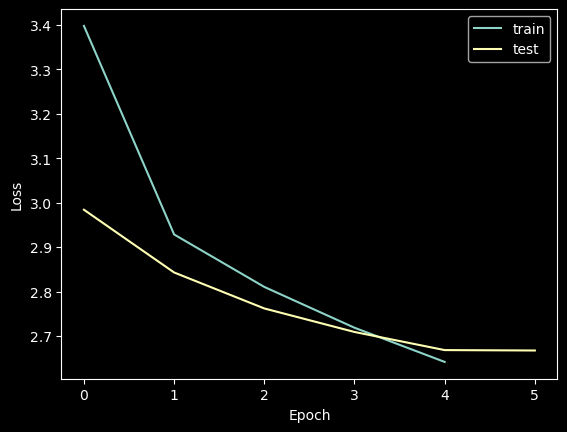

In [15]:
trainer.plot_loss()

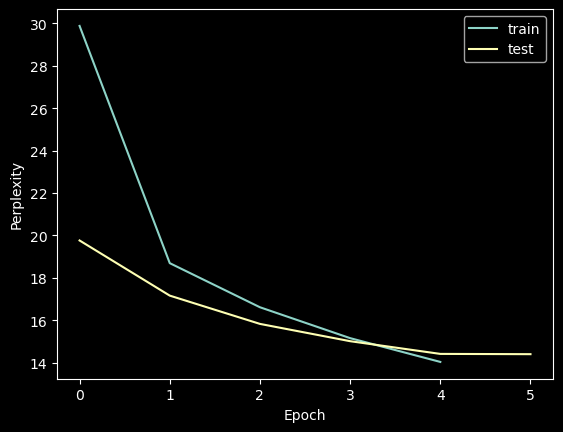

In [16]:
trainer.plot_perplexity()

## Evaluate your model

In the `evaluate.py`, it provides some useful function for the evaluation of the model

The function `evaluate()` would generate predictions on the whole corpus and get the **BLEU** and **Edit Distance** score for the model

In this function, you need to input your model, dataloader, vocabulary, and device

In [16]:
from evaluate import evaluate

evaluate(model, test_loader, vocab_dict, device)
for batch_idx, (image_tensors, formulas_indexed) in enumerate(test_loader):
    print(image_tensors.shape)

Prediction Process [0/10 (0%)]
Prediction Finished
Bleu score on 10 samples: 0.007109520481954577
Edit distance score on 10 samples: 0.08568781843446038
torch.Size([8, 1, 64, 384])
torch.Size([2, 1, 64, 256])


Or if you want to generate the prediction only for one or several images, you can call `predict()` of the model

Use `detokenize()` to convert index into tokens. It is important to keep the consistency of the vocabulary.

In [ ]:
from evaluate import detokenize

image = image_tensors[0].unsqueeze(0).to(device)

pred = model.predict(image)

detokenize(pred, vocab_dict)

## Save your model

The function `save_model()` takes `model`, `vocab_dict`, `filename`, `path` as the input

- `vocab_dict` is the vocabulary dictionary

- `filename` is the file name that you want your saved file to have

Note: You need to add suffix for your file (e.g. if you want your file to be called `transformer`, then you need to input `transformer.pth` or something else)

- **The target directory must exist**

In [25]:
# from model import save_model

# target_dir = "./save_models/"
# filename = "test.pth"

# save_model(model, vocab_dict, filename, target_dir)

Model saved to ./save_models/test.pth
